Análisis de Datos en Meteorología.

Práctica 1: Lectura y exploración inicial de datos.

Grupo 2:
- Marta Covadonga Barbolla Galán 
- Diego García Maroto
- Victor Galván Fraile
- Nagore Meabe Yanguas
- Covadonga Galán Fernández

## Imports

In [19]:
# Librerías necesarias para realizar la práctica
# -----------------------------------------------------
# Manipulación y lectura de datos
import netCDF4 as nc
import pandas as pd
import xarray as xr
import numpy as np
import numpy.ma as ma
from datetime import timedelta,datetime

# Estadistica
from scipy import stats

# Visualización de datos
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.io.shapereader as shpreader
import seaborn as sns
import cartopy.crs as ccrs
import cmocean as cmo #Oceanographic library for colormaps
# Para instalar el último módulo: conda install -c conda-forge cmocean

import math
import warnings
warnings.filterwarnings('ignore')

In [20]:
from matplotlib import style
plt.style.use('seaborn')

## Apartado 1

### 1.1 Análisis de la temperatura media diaria con datos de estación.

#### 1.1.1: Lectura de datos ISD de Barajas y boxplot

In [21]:
stationName = 'BARAJAS'

In [22]:
def readDataFrame(stationName):
    url = 'https://www.ncei.noaa.gov/pub/data/noaa/isd-history.csv'
    c=pd.read_csv(url)

    #Seleccionamos los años de inicio y final de lectura
    yearInit = 1973
    yearEnd = 2020

    #Construimos el código que necesitamos para bajar los datos de la estación:
    station=str(c.loc[(c['STATION NAME']==stationName)]['USAF'].values[0]) + '-' + \
            str(c.loc[(c['STATION NAME']==stationName)]['WBAN'].values[0])
    print('Seleccionada la estacion ' + stationName + ' con código ' + station)

    #Definimos las columnas y el tipo de dato que va a tener el DataFrame donde vamos a alojar los datos de la estación
    colNames=['year','month','day','hour','temp','tempd','slp','windDir','windSpeed','cloud','pcp1h','pcp6h']
    dataType=['int','int','int','int','float','float','int','int','int','int','int','int',]

    #Definimos los límites de los caractéres donde están los datos en los archivos que vamos a leer 
    #(Esta información está en: https://www.ncei.noaa.gov/pub/data/noaa/isd-lite/isd-lite-format.txt)
    #D: de la página sacamos las posiciones en el str en la que está cada tipo de datos (cada columna) y la pasamos:
    limits=[(0,4),(5,7),(8,10),(11,13),(14,19),(20,25),(26,31),(32,37),(38,43),(44,49),(50,55),(56,61)]
    
    #Lectura de los datos:
    df=pd.DataFrame(columns=colNames)
    concat_list = []
    for iyr in range(yearInit, yearEnd, 1):
        fil='https://www.ncei.noaa.gov/pub/data/noaa/isd-lite/'+str(iyr)+'/'+station +'-'+ str(iyr)+'.gz'
        data= pd.read_fwf(fil,sep=' ',compression='gzip',head=0,
                     names=colNames,colspecs=limits)
        #df = df.append(data)
        concat_list.append(data)
    df=pd.concat(concat_list)

    #Cambio el tipo de dato (porque los lee como objetos str y queremos que sean numéricos)
    dictType={ colNames[i] : dataType[i] for i in range(12)} #D: Creamos un diccionario con cada nombre de columna y su data type
    data = df.astype(dictType,copy=True) #D: pasamos el dict a Pandas para que haga las conversiones 

    #Los datos missing son -9999 en la base de datos: cambiamos por NaN:
    data = data.replace(-9999,np.NaN)

    # Cambio las unidades de la temperatura a ºC
    data['temp']/=10
    data['tempd']/=10

    
    dataDailyMax = data.groupby(['year','month','day']).max().drop(['hour'],axis=1).reset_index()
    dataDailyMax['time'] = pd.to_datetime(dataDailyMax[['year','month','day']],yearfirst=True)
    dataDailyMax = dataDailyMax.set_index('time')
    dataDailyMin = data.groupby(['year','month','day']).min().drop(['hour'],axis=1).reset_index()
    dataDailyMin['time'] = pd.to_datetime(dataDailyMin[['year','month','day']],yearfirst=True)
    dataDailyMin = dataDailyMin.set_index('time')
    dataDailyCum = data.groupby(['year','month','day']).sum().drop(['hour'],axis=1).reset_index()
    dataDailyCum['time'] = pd.to_datetime(dataDailyCum[['year','month','day']],yearfirst=True)
    dataDailyCum = dataDailyCum.set_index('time')
    dataDailyMean = data.groupby(['year','month','day']).mean().drop(['hour'],axis=1).reset_index()
    dataDailyMean['time'] = pd.to_datetime(dataDailyMean[['year','month','day']],yearfirst=True)
    dataDailyMean = dataDailyMean.set_index('time')
    return dataDailyMean

dayMean = readDataFrame(stationName)

Seleccionada la estacion BARAJAS con código 082210-99999


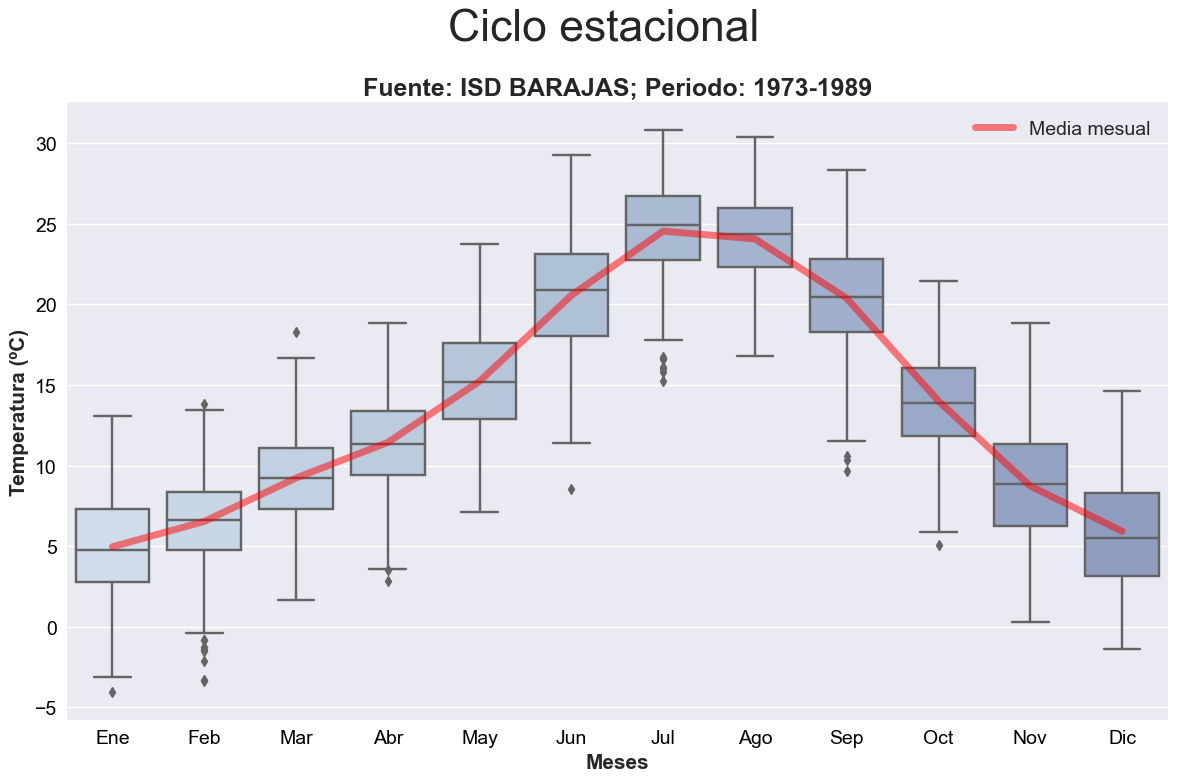

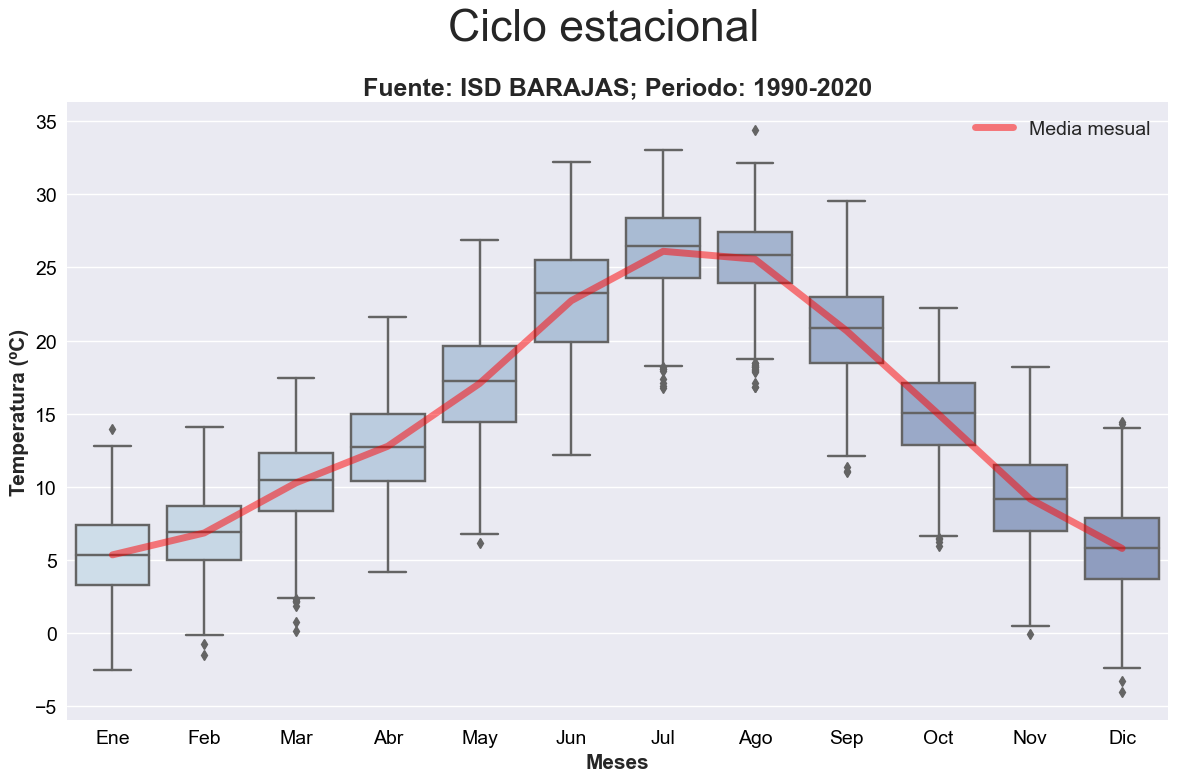

In [23]:
cus = sns.color_palette("ch:start=0.2,rot=-0.2,dark=0.6, light=.85",12) # Paleta de color elegida
#cus = sns.color_palette("ch:start=0.2,rot=-0.5,dark=0.6, light=.9",12) # Paleta de color elegida

def climograma(df,start_year,end_year,save=False,violin = False, outliers = True, figname='barajas',fuente='',palette=cus):
    ''' 
    Función para realizar boxplots del ciclo estacional a partir de unos datos de temperatura a 2m.

    Entradas:
    - df: DataFrame con los datos de temperatura, extructurado por columnas de 'day','month','year','temp'
    - start_year: año de inicio del periodo que queremos representar 
    - end_year: año de fin del periodo que queremos representar 
    - save: si se quiere guardar la figura poner save=1
    - violin: si se quiere represnetar un diagrama de violines poner violin=1
    - outliers: si se quieren quitar los outliers del boxplot poner outliers=0
    - figname: nombre para el png si se pide guardar 'figname'+'.png'
    - fuente: str con el nombre de la fuente de los datos 
    - palette: paleta de colores que se quiere usar

    Salidas:
    - Tupla con la figura (fig) y el axis (ax) donde se representa el plot.
    
    '''
    df = df[(start_year <= df['year'])&(df['year'] <= end_year)]    # Selecciono los años
    means = df.groupby(['month'],dropna=True).mean('temp')          # Media de cada mes para representar encima    
    fig, ax = plt.subplots(figsize=(12,8))
    meses = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic'] # Nombres de los meses para los xtick
    if violin == True: # Si queremos representarlo como violines
        sns.violinplot(data=df, x='month', y='temp', ax=ax, showfliers = False)
    else: 
        if outliers == True: # Boxplot con outliers 
            sns.boxplot(data=df, x='month', y='temp', ax=ax,zorder=2,palette=palette) #,whis=2)
            
        else: # Boxplot sin outliers 
            sns.boxplot(data=df, x='month', y='temp', ax=ax, showfliers = False,boxprops=dict(alpha=.7,zorder= 2),zorder=2)


    # Plot de la línea de medias
    ax.plot(np.arange(12), means['temp'],linewidth=5, color ='r',zorder=3, alpha=0.5, label='Media mesual')
    # Ajustes del ax
    ax.set_ylabel('Temperatura (ºC)', size=15 , fontweight = 'bold')
    ax.set_xlabel('Meses', size=15, fontweight = 'bold')
    ax.set_xticks(np.arange(12),meses,size=14) # Para cambiar las etiquetas a los nombres de meses
    ax.yaxis.set_tick_params(labelsize=14)
    ax.legend(prop={'size':14})

    mid = (fig.subplotpars.right + fig.subplotpars.left)/2 # Para alinear el title y el suptitle
    plt.suptitle('Ciclo estacional',size=32, x=mid)
    plt.title(u'Fuente: %s; Periodo: %i-%i'%(fuente,start_year,end_year), size=18)
    plt.tight_layout()
    if save == True:  # Si queremos guardar la figura
        fig.savefig(figname+'.png',dpi=500,facecolor='w')
        
    return fig, ax

fig, ax = climograma(dayMean,1973,1989, fuente='ISD '+stationName,save=True,figname='barajas_boxplot_7389')
fig, ax = climograma(dayMean,1990,2020, fuente='ISD '+stationName,save=True,figname='barajas_boxplot_9020')

#### 1.1.2 Caracterización de la distribución para enero y julio Para los meses de enero y julio separadamente.

In [24]:
daily_mean_firstperiod = dayMean[dayMean['year']<1991]
daily_mean_secondperiod = dayMean[dayMean['year']>=1991]

In [25]:
january_daily_mean_firstperiod  = daily_mean_firstperiod[daily_mean_firstperiod['month']==1]
july_daily_mean_firstperiod     = daily_mean_firstperiod[daily_mean_firstperiod['month']==7]
january_daily_mean_secondperiod = daily_mean_secondperiod[daily_mean_secondperiod['month']==1]
july_daily_mean_secondperiod    = daily_mean_secondperiod[daily_mean_secondperiod['month']==7]

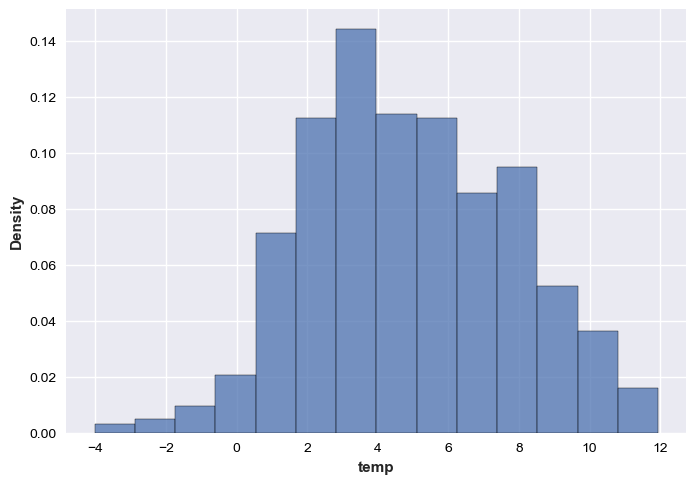

In [26]:
def histogram_plotter(data,variable):
    bins= np.arange(np.min(data[variable]),np.max(data[variable]),step=(np.max(data[variable])-np.min(data[variable]))/15)
    fig,ax= plt.subplots()
    sns.histplot(data, x=variable,bins=bins,kde = False, stat='density')

histogram_plotter(january_daily_mean_firstperiod,'temp')

In [27]:
def histogram_plotter_with_normal_estimation(data:pd.DataFrame,variable:str,variable_name:str,title:str, verbose:bool=True) -> None:
    """
    description:
    --------------------------------------
    
    arguments:
        - data: entry dataframe
        - variable: name of the variable of study
        - title: plot title
        - verbose: True if you want the stats asociated with the variable
    """
    mean= np.mean(data[variable])
    std= np.std(data[variable])
    n= np.shape(data[variable])[0]
    bins= np.arange(np.min(data[variable]),np.max(data[variable]),step=(np.max(data[variable])-np.min(data[variable]))/20)
    fig,ax= plt.subplots()
    sns.histplot(data, x=variable,bins=bins,stat='density')
    normal_distribution= stats.norm.pdf(bins,mean,std)
    plt.plot(bins,normal_distribution,'red',label='Theoric')
    plt.legend(loc='best')
    plt.xlabel(variable_name)
    plt.title(title)
    plt.show()
    quantile_data= np.quantile(data[variable],(0.05,0.95))
    quantile_theoric= [stats.norm.ppf(0.05,mean,std),stats.norm.ppf(0.95,mean,std)]
    if verbose:
        print('Percentiles for the data are: q(5%%)=%.2f and q(95%%)= %.2f' %(quantile_data[0],quantile_data[1]))
        print('Percentiles for the theoric distribution are: q(5%%)=%.2f and q(95%%)= %.2f' %(quantile_theoric[0],quantile_theoric[1]))
        print('Índice de Confianza del 95%')
        alfa=0.05
        #We must use the t-student distribution, beacuse with don't now the standard deviation of the data
        t_alpha_2= stats.t.ppf(1-alfa/2,n-1)
        ic= t_alpha_2*std/np.sqrt(n)
        print('IC= [%.2f+-%.2f] (ºC)'%(mean,ic))
        print('With scipy function:')
        ic_scipy=stats.t.interval(alpha=0.95,df=n-1,loc=mean,scale= std/np.sqrt(n))
        print(ic_scipy)

daily_mean= dayMean
daily_mean    
january_daily_mean= daily_mean[daily_mean['month']==1]
july_daily_mean= daily_mean[daily_mean['month']==7]
periods= ['1973-2019','1973-1990','1990-2019']

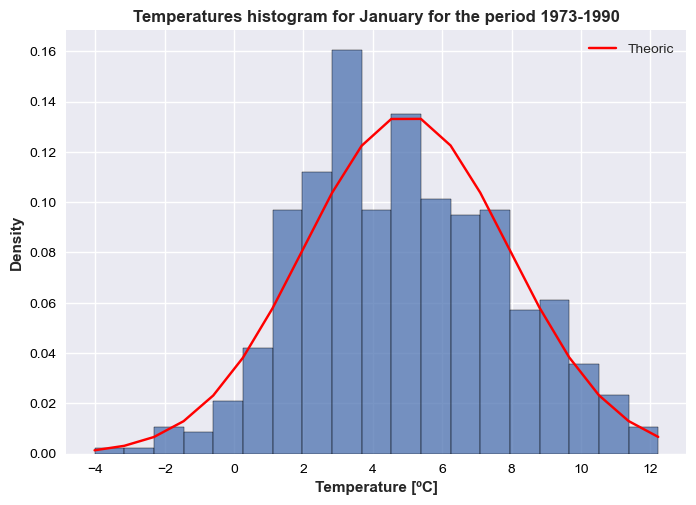

Percentiles for the data are: q(5%)=0.76 and q(95%)= 9.98
Percentiles for the theoric distribution are: q(5%)=0.08 and q(95%)= 9.84
Índice de Confianza del 95%
IC= [4.96+-0.25] (ºC)
With scipy function:
(4.715694291295338, 5.209054816669593)


In [28]:
histogram_plotter_with_normal_estimation(january_daily_mean_firstperiod,'temp','Temperature [ºC]','Temperatures histogram for January for the period '+periods[1])

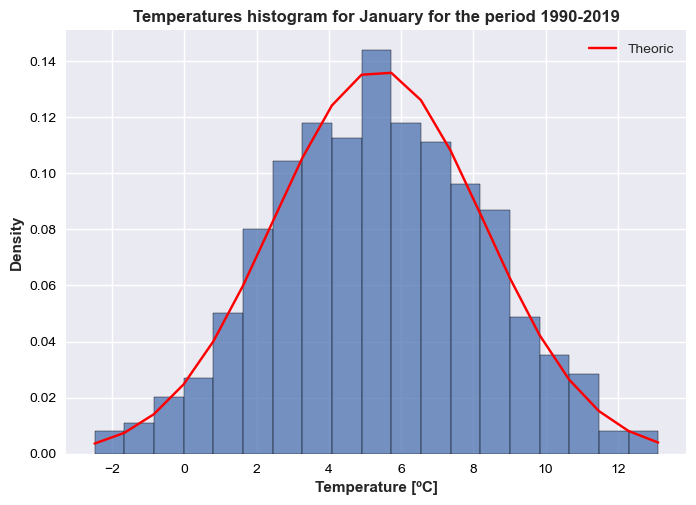

Percentiles for the data are: q(5%)=0.61 and q(95%)= 10.24
Percentiles for the theoric distribution are: q(5%)=0.57 and q(95%)= 10.16
Índice de Confianza del 95%
IC= [5.37+-0.19] (ºC)
With scipy function:
(5.1776024608975, 5.5593393426689115)


In [29]:
histogram_plotter_with_normal_estimation(january_daily_mean_secondperiod,'temp','Temperature [ºC]','Temperatures histogram for January for the period '+periods[2])

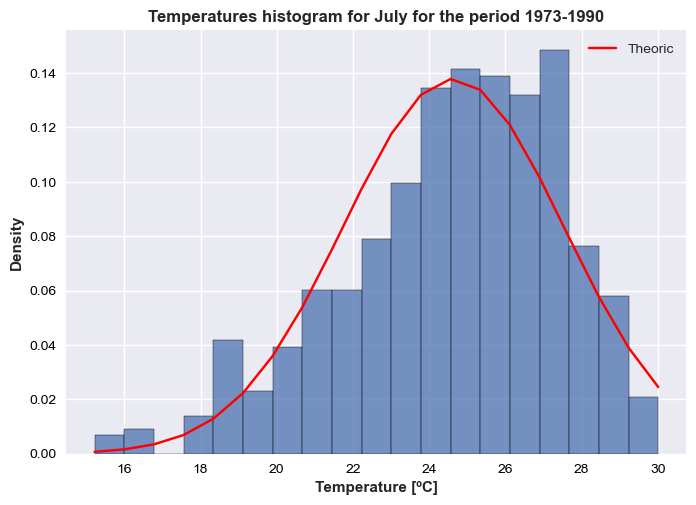

Percentiles for the data are: q(5%)=19.03 and q(95%)= 28.64
Percentiles for the theoric distribution are: q(5%)=19.88 and q(95%)= 29.40
Índice de Confianza del 95%
IC= [24.64+-0.24] (ºC)
With scipy function:
(24.396141159662047, 24.87730603313938)


In [30]:
histogram_plotter_with_normal_estimation(july_daily_mean_firstperiod,'temp','Temperature [ºC]','Temperatures histogram for July for the period '+periods[1])

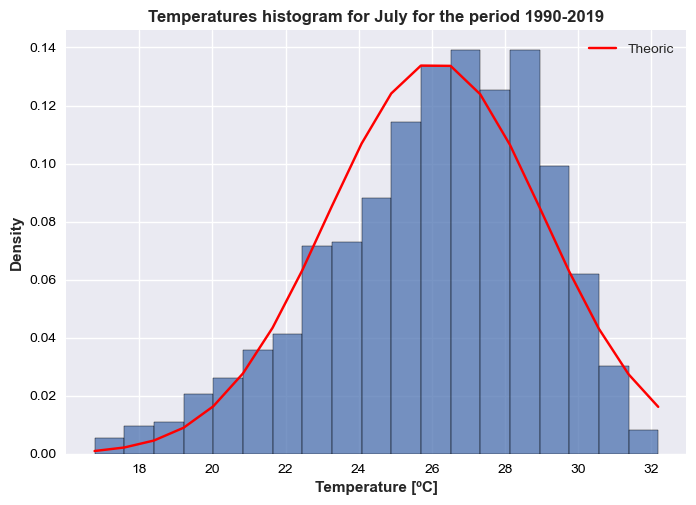

Percentiles for the data are: q(5%)=20.42 and q(95%)= 30.26
Percentiles for the theoric distribution are: q(5%)=21.24 and q(95%)= 30.96
Índice de Confianza del 95%
IC= [26.10+-0.19] (ºC)
With scipy function:
(25.90527380462021, 26.292215963747292)


In [31]:
histogram_plotter_with_normal_estimation(july_daily_mean_secondperiod,'temp','Temperature [ºC]','Temperatures histogram for July for the period '+periods[2])

#### 1.1.3 Cambio climático. 
Calcula la media de la temperatura en enero y julio para el periodo 1973-1989. Calcula la desviación típica de la temperatura en enero y julio para el periodo 1973-1989 y el periodo 1990-2019. Haz los contrastes de hipótesis pertinentes para decir si ha cambiado significativamente la temperatura en Barcelona en ambos periodos.

In [32]:
# Voy a hacer una clase para los testats estadísticos

class StadisticalTestats():
    # El método __init__ incluye toda la lógica necesaria para los índices de entrada y etiqueta.
    def __init__(self, x, y, alpha) -> None:
        
        self.x     = x
        self.y     = y
        self.alpha = alpha
   
    def f_test_stats(self) -> float:
        """
            Metodo que calcula el resultado p del test de Fisher para las varianzas, utilizando funciones de scipy.stats.

        Returns:
            float: el valor p. Si nuestro alpha que solemos determinarlo en 0.05, es mayor que p entonces nuestra hipotesis se acepta
                   en cambio, si el manor, debemos rechazar la hipotesis realizada.
        """
        
        # Cálculo del estadístico
        f = np.var (self.x, ddof = 1) /np.var (self.y, ddof = 1)
        
        # Calculo de la p si esta es menor que 0.05 la aceptamos
        p = 1- stats.f.cdf (f, self.x.size-1, self.y.size-1) 
        return p
    
    def _f_fisher(self):
   
        n1 = self.x.size
        n2 = self.y.size
        
        f = stats.f.interval(self.alpha, n1, n2, loc=0, scale=1)
        return f
    
    def f_test_manual(self) -> bool:
        """
            Otro método para calcular el test de Fisher pero esta vez implementado de manera manual.
        
        Returns:
            bool: si el estadístico calculado, f , está dentro de nuestro intervalo de significancia
                devolvemos True sino False.
        """
        # Cálculo del estadístico
        f = np.var (self.x, ddof = 1) /np.var (self.y, ddof = 1)
        f=1 # porque suponemos que son iguales
        
        # Intervalo de significancia con el alpha que hemos determinado
        isig = self._f_fisher()
        
        # Aceptamos o no la hipotesis?
        if f > isig[0] and f<isig[1]:
            print(f'Se ha aceptado la hipotesis de que las varianzas son iguales con una confianza de {self.alpha}.')
            return True
        else:
            print(f'Se ha rechazado la hipotesis de que las varianzas son iguales con una confianza de {self.alpha}.')
            return False
    
    def _z(self):
        
        z = abs(np.mean(self.x) - np.mean(self.y)) / np.sqrt(np.var(self.x,ddof=1) / self.x.size + np.var(self.y,ddof=1) / self.y.size)
        return z

    def mean_test(self) -> bool:
        # Calculo valor con el que voy a comparar mi muestra
        z_alpha_2 = stats.norm.ppf(1-self.alpha/2)
    
        z = self._z()
        
        if z <= z_alpha_2:
            # Se acepta la hipotesis
            print(f'Se ha aceptado la hipotesis de que las medias son iguales con una confianza de {self.alpha}.')
            # return True
        else:
            # Se anula la hipotesis
            print(f'Se ha rechazado la hipotesis de que las medias son iguales con una confianza de {self.alpha}.')
            # return False
        
    def mean_test_stats(self):

        return stats.ttest_ind(self.x, self.y, nan_policy='omit', equal_var=False)
    
    #                      Documentation
    # ----------------------------------------------------------------------------------
    #     A p-value larger than a chosen threshold (e.g. 5% or 1%) indicates that
    # our observation is not so unlikely to have occurred by chance. Therefore,
    # we do not reject the null hypothesis of equal population means.
    # If the p-value is smaller than our threshold, then we have evidence
    # against the null hypothesis of equal population means.
    
    # El 5% quiero dejarlo fuera, lo de dentro son igual si lo rechazo me entra dentro en
    # el p-value
    

In [33]:
# Guardamos las variables de temperatura para usarlas en el contraste 
enero_first = january_daily_mean_firstperiod ['temp']
julio_first = july_daily_mean_firstperiod    ['temp']
enero_last = january_daily_mean_secondperiod ['temp']
julio_last = july_daily_mean_secondperiod    ['temp']

In [34]:
# Enero
alpha = 0.05
a = StadisticalTestats(x=julio_first, y=julio_last, alpha  = alpha)
b = StadisticalTestats(x=enero_first, y=enero_last, alpha = alpha)

In [35]:
# Para julio
a.mean_test()
a.mean_test_stats()

a.f_test_manual()
a.f_test_stats()


# Enero
b.mean_test()
b.mean_test_stats()


b.f_test_manual()
b.f_test_stats()

Se ha rechazado la hipotesis de que las medias son iguales con una confianza de 0.05.
Se ha aceptado la hipotesis de que las varianzas son iguales con una confianza de 0.05.
Se ha rechazado la hipotesis de que las medias son iguales con una confianza de 0.05.
Se ha aceptado la hipotesis de que las varianzas son iguales con una confianza de 0.05.


0.315114760527725

### 1.2 Análisis de la temperatura media diaria con datos de la base CPC de temperatura global diaria.

#### 1.2.1 Caracterización del ciclo estacional

In [36]:
path='./data/CPC_global_daily/'
files=['tmean_PI_mes_{}.nc'.format(i) for i in range(1,13)]

lon_barajas = -3.567
lat_barajas = 40.494

df_arr = np.empty((1,3))

for file in files:
    fil = nc.Dataset(path + file,'r')
    lon = fil.variables['lon'][:]
    lat = fil.variables['lat'][:]
    tiempo = fil.variables['time'] #sin los dos puntos para que sea variable ncdf
    tmedia = fil.variables['tmean'][:]

    lon_i = np.abs(lon-lon_barajas).argmin()
    lat_i = np.abs(lat-lat_barajas).argmin()

    temp = tmedia[:,lat_i,lon_i]
    tiempodates = nc.num2date(tiempo[:],tiempo.units) #ahora es un array de tiempos

    fechas = np.array([[fecha.month,fecha.year] for fecha in tiempodates])

    df_arr_i = np.c_[temp,fechas]
    df_arr = np.r_[df_arr,df_arr_i]



df1 = pd.DataFrame(df_arr[1:,:],columns=['temp','month','year']).astype({'month':int,'year':int}).dropna()

# hay un dato que hace que la representación falle, por eso seleccionamos todos 
# los valores de temperatura que estén por encima de los 0 grados

df = df1.loc[df1["temp"] >= -7 ]

print(lon[lon_i])
print(lat[lat_i])

-3.75
40.25


In [37]:
df

,temp,month,year
0,7.234882,1,1990
1,5.883603,1,1990
2,7.588984,1,1990
3,6.497338,1,1990
4,6.446887,1,1990
...,...,...,...
10952,8.648129,12,2019
10953,8.165260,12,2019
10954,7.994678,12,2019
10955,6.663296,12,2019


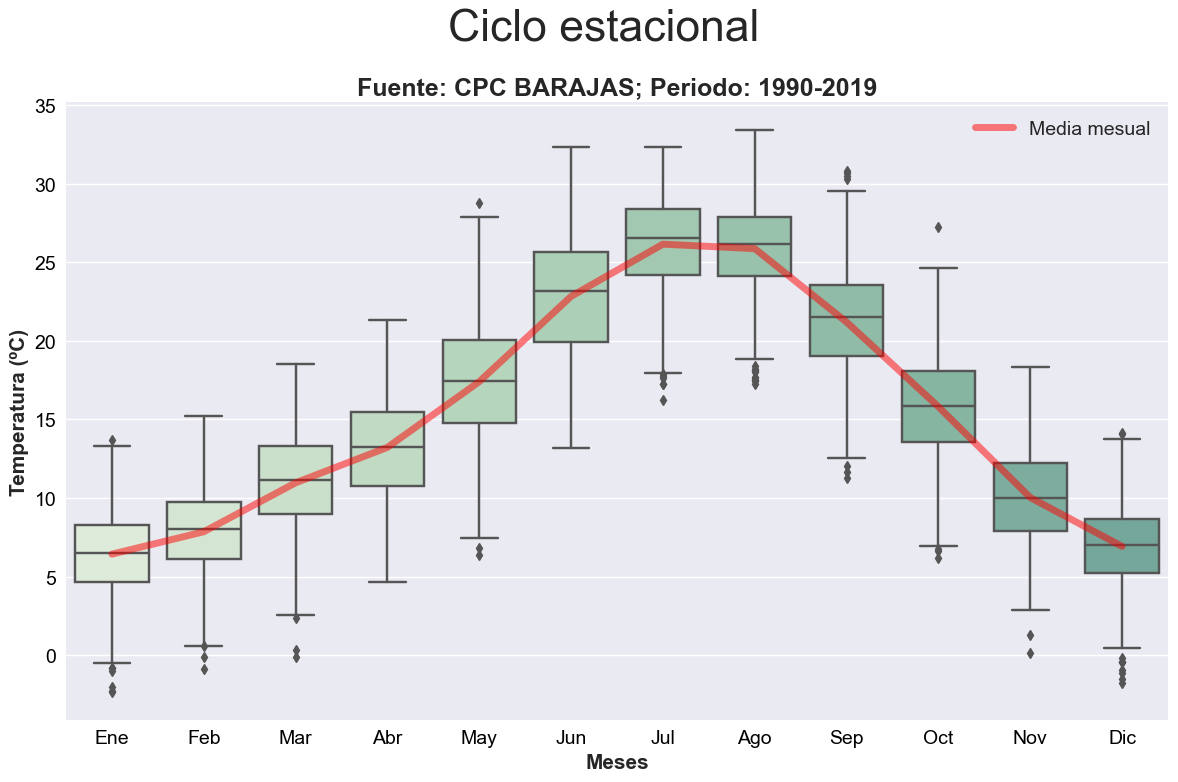

In [38]:
# Usamos la función de boxplot que hicimos, con otra paleta de color
cus = sns.color_palette("ch:start=0.2,rot=-0.5,dark=0.6, light=.9",12) # Paleta de color elegida
fig,ax = climograma(df, 1990, 2019, fuente = 'CPC BARAJAS', palette=cus)

#### 1.2.2 Caracterización de la distribución para enero y julio 
Repite el cálculo del apartado 1.1.2 con
los datos de CPC. Comenta los resultados y las diferencias/semejanzas con lo obtenido en el
apartado 1.1.2.

In [39]:
# Seleccionamos los meses
enero_1990_2019= df[df['month']==1]
julio_1990_2019= df[df['month']==7]

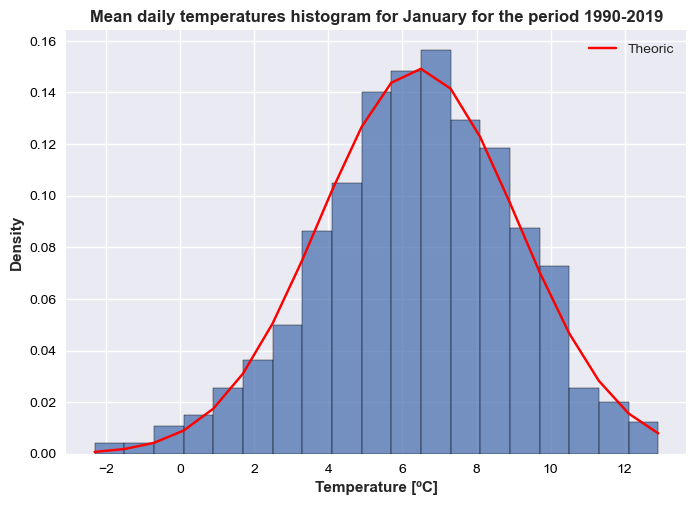

Percentiles for the data are: q(5%)=1.92 and q(95%)= 10.50
Percentiles for the theoric distribution are: q(5%)=2.03 and q(95%)= 10.82
Índice de Confianza del 95%
IC= [6.43+-0.17] (ºC)
With scipy function:
(6.255606741328608, 6.5996716741205965)


In [40]:
histogram_plotter_with_normal_estimation(enero_1990_2019,'temp','Temperature [ºC]','Mean daily temperatures histogram for January for the period 1990-2019')

{'whiskers': [<matplotlib.lines.Line2D at 0x27631f674f0>,
 'caps': [<matplotlib.lines.Line2D at 0x27631f67a60>,
 'boxes': [<matplotlib.lines.Line2D at 0x27631f672b0>],
 'medians': [<matplotlib.lines.Line2D at 0x27631f75040>],
 'fliers': [<matplotlib.lines.Line2D at 0x27631f75310>],
 'means': []}

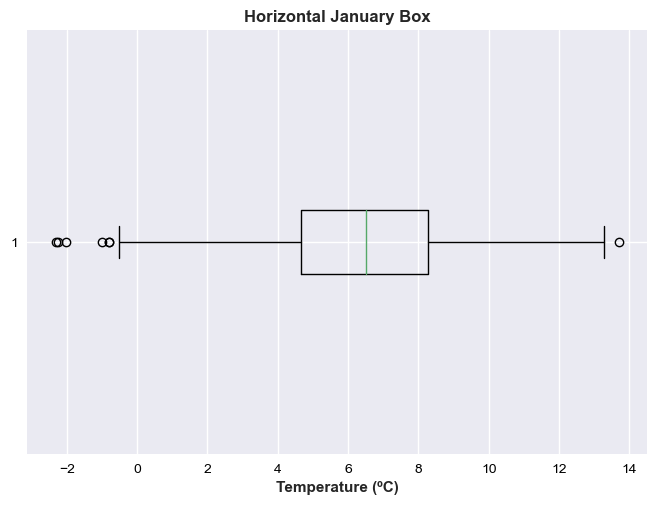

In [41]:
# box plot horizontal para el mes de enero

fig5, ax5 = plt.subplots()
ax5.set_title('Horizontal January Box')
ax5.set_xlabel('Temperature (ºC)')
ax5.boxplot(df[df['month']==1]['temp'], vert=False)

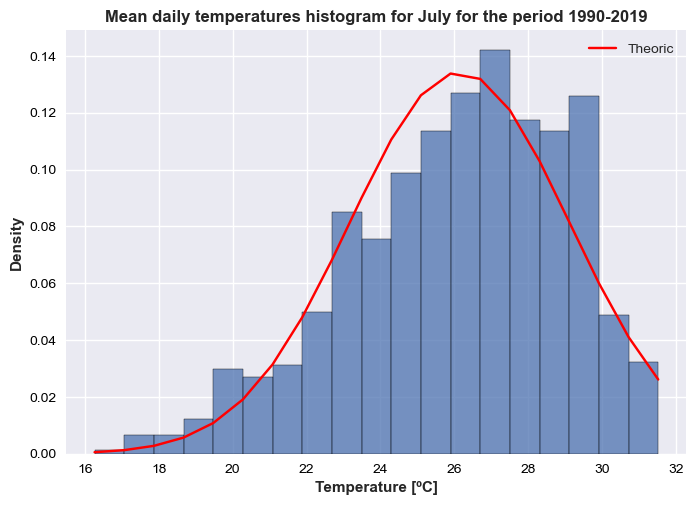

Percentiles for the data are: q(5%)=20.59 and q(95%)= 30.33
Percentiles for the theoric distribution are: q(5%)=21.26 and q(95%)= 31.03
Índice de Confianza del 95%
IC= [26.14+-0.19] (ºC)
With scipy function:
(25.951965449856605, 26.334596296401923)


In [42]:
histogram_plotter_with_normal_estimation(julio_1990_2019,'temp','Temperature [ºC]','Mean daily temperatures histogram for July for the period 1990-2019')

{'whiskers': [<matplotlib.lines.Line2D at 0x2763216b190>,
 'caps': [<matplotlib.lines.Line2D at 0x2763215e760>,
 'boxes': [<matplotlib.lines.Line2D at 0x2763216b4f0>],
 'medians': [<matplotlib.lines.Line2D at 0x2763215eaf0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2763215e310>],
 'means': []}

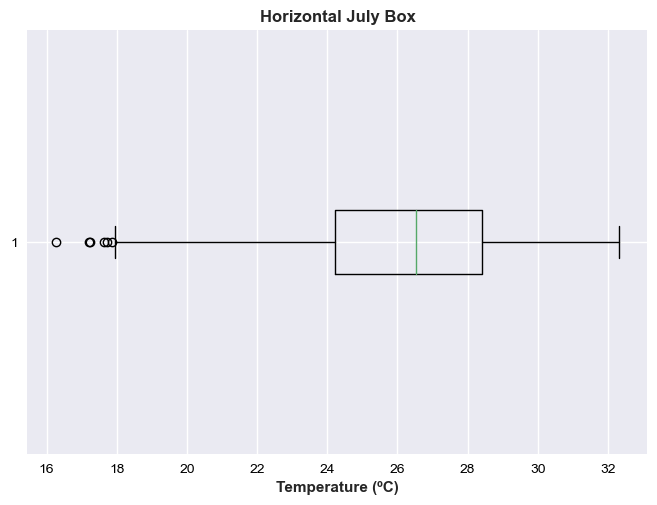

In [43]:
# box plot horizontal para el mes de julio

fig6, ax6 = plt.subplots()
ax6.set_title('Horizontal July Box')
ax6.set_xlabel('Temperature (ºC)')
ax6.boxplot(df[df['month']==7]['temp'], vert=False)

#### 1.2.3.Análisis de la consistencia entre los datos de estación y del CPC 
Para enero y julio
separadamente evalúa la consistencia de los datos. Para ello, realiza un contraste de hipótesis
bilateral acerca de la diferencia entre la media de los datos obtenidos en la estación de Barajas y la
obtenida del punto de malla más próximo de CPC. ¿Es rechazable la hipótesis de que las dos
muestras vienen de la misma población?

In [44]:
# Los datos ISD son enero_last y julio_last
alfa = 0.05
jan = StadisticalTestats(x=enero_1990_2019['temp'], y=enero_last, alpha  = alfa)
jul = StadisticalTestats(x=julio_1990_2019['temp'], y=julio_last, alpha = alfa)

In [45]:
# Resultados para enero
jan.f_test_manual()
jan.mean_test()

Se ha aceptado la hipotesis de que las varianzas son iguales con una confianza de 0.05.
Se ha rechazado la hipotesis de que las medias son iguales con una confianza de 0.05.


In [46]:
# Resultados para julio
jul.f_test_manual()
jul.mean_test()

Se ha aceptado la hipotesis de que las varianzas son iguales con una confianza de 0.05.
Se ha aceptado la hipotesis de que las medias son iguales con una confianza de 0.05.


### 1.3 : Análisis con datos del reanálisis NCEP/NCAR 

Lee los datos para cada meses por separado y selecciona el punto de la malla que esté más próximo a Barajas (40.494oN, 3.567oW).


#### 1.3.1 Caracterización del ciclo estacional. 

Caracteriza el ciclo estacional de la temperatura media diaria en superficie en Barajas empleando boxplots: En un mismo gráfico dibuja 12 diagramas de cajas y bigotes para caracterizar los datos de cada mes por separado. Puedes incluir la media de cada mes con una línea. Comenta los resultados.


In [47]:
# Path del directorio donde se guardan los datos 
path='./data/NCEP-NCAR/'

# Lista con el nombre de los archivos que guardan la información de cada mes
meses_NCEP=['NCEP_NCAR_air_PI_mes_{}.nc'.format(i) for i in range(1,13)] # Lista con todos los nombres de los archivos

In [48]:
# Se fija la latitud y longitud del aeropuerto de Barajas
lon_barajas = -3.567
lat_barajas = 40.494

In [49]:
df_arr = np.empty((1,4)) # Array vacio para empezar a introducirle los datos (1 fila vacia, 4 columnas)

for file in meses_NCEP: # Bucle a lo largo de todos los nombres de archivo
    fil = nc.Dataset(path + file,'r') # Leemos con netCDF4
    lon = fil.variables['lon'][:] # Asignamos las variables
    lat = fil.variables['lat'][:]
    tiempo = fil.variables['time'] # Se escribe sin los dos puntos para que sea variable ncdf, con ellos es un masked array
    tmedia = fil.variables['air'][:]
    tmedia=tmedia-273.15 # Pasar las temperaturas a Kelvin
    
    # Calculamos los índices de latitud y longitud más cercanos a las de barajas con argmin
    lon_i = np.abs(lon-lon_barajas).argmin()
    lat_i = np.abs(lat-lat_barajas).argmin()

    temp = tmedia[:,lat_i,lon_i] # Seleccionamos esos valores de lat y lon para las temperaturas
    tiempodates = nc.num2date(tiempo[:],tiempo.units) # Cambiamos el tiempo a un array con el formato de las fechas Dia-Mes-Año

    fechas = np.array([[fecha.day, fecha.month, fecha.year] for fecha in tiempodates]) # Separamos las fechas en un array de dias, meses y años

    df_arr_i = np.c_[fechas,temp]   # Concatenamos en el segundo eje las temperaturas y las fechas
    df_arr = np.r_[df_arr,df_arr_i] # Añadimos al array conjunto con todos los meses


# Transformamos la lista conjunta a un dataframe dando los nombres de las columnas y los tipos de variables
df = pd.DataFrame(df_arr[1:,:],columns=['day','month','year','temp']).astype({'day':int, 'month':int,'year':int}).dropna()

# Imprimimos el DataFrame
df

,day,month,year,temp
0,1,1,1990,1.730011
1,2,1,1990,0.000000
2,3,1,1990,2.930023
3,4,1,1990,0.079987
4,5,1,1990,-1.519989
...,...,...,...,...
10952,27,12,2019,0.925018
10953,28,12,2019,-0.074982
10954,29,12,2019,-1.524994
10955,30,12,2019,-2.100006


In [50]:
# En el DataFrame se eliminan los datos que difieren demnasiado de los valores, por posibles errores en el reanalisis y se cambian por NaN
display(df[-50 > df['temp']])   
df[-50 > df['temp']]  = np.NaN  # Lo cambio por NaN
df[100 < df['temp']]  = np.NaN

,day,month,year,temp


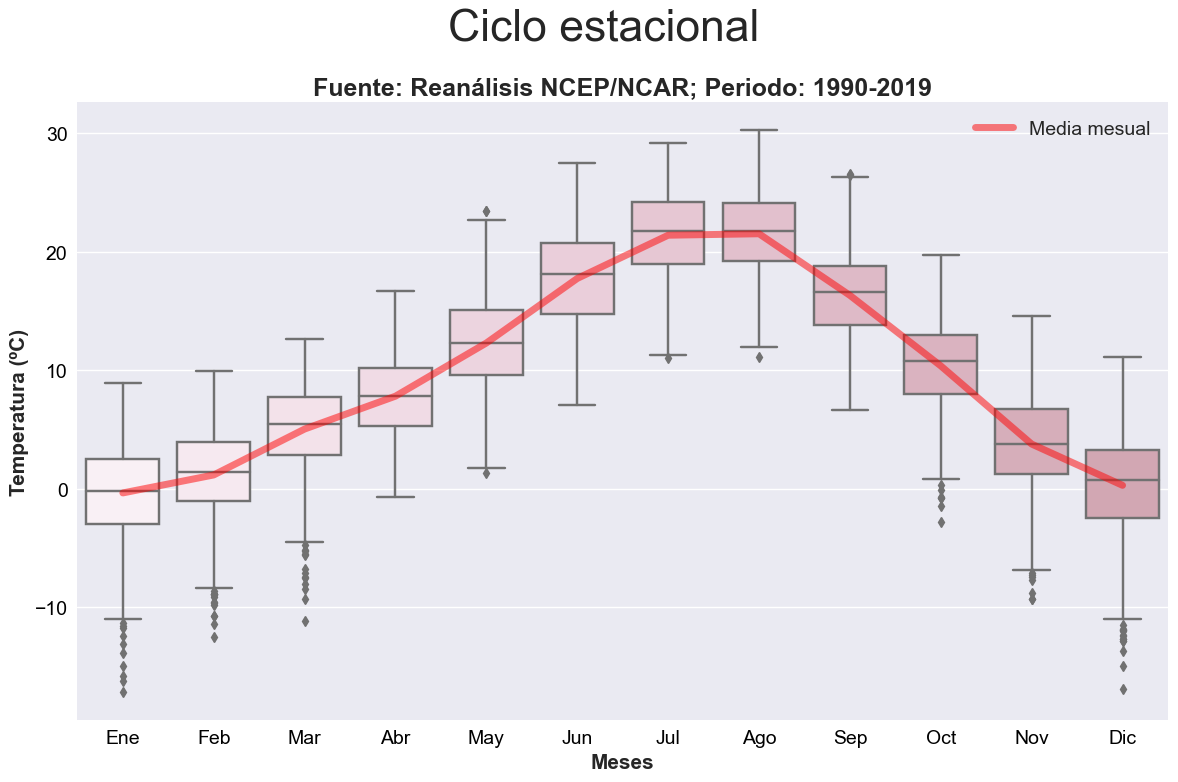

In [51]:
# Usamos la función de boxplot que hicimos, con otra paleta de color
cus = sns.color_palette("ch:start=1.2,rot=-0.2,dark=0.7, light=.95",12) # Paleta de color elegida
fig, ax = climograma(df,1990,2019,fuente=u'Reanálisis NCEP/NCAR',palette=cus)

#### 1.3.2 Caracterización de la distribución para enero y julio.

Repetir el cálculo del apartado 1.1.2 con los datos del CPC. Comentar los resultados y las diferencias/semejanzas con lo obtenido en anteriores apartados

In [52]:
# Los datos de esta base están dados como temperaturas medias diarias, por lo que se tomarán los meses de enero y julio.
media_diaria_enero= df[df['month']==1]
media_diaria_julio= df[df['month']==7]

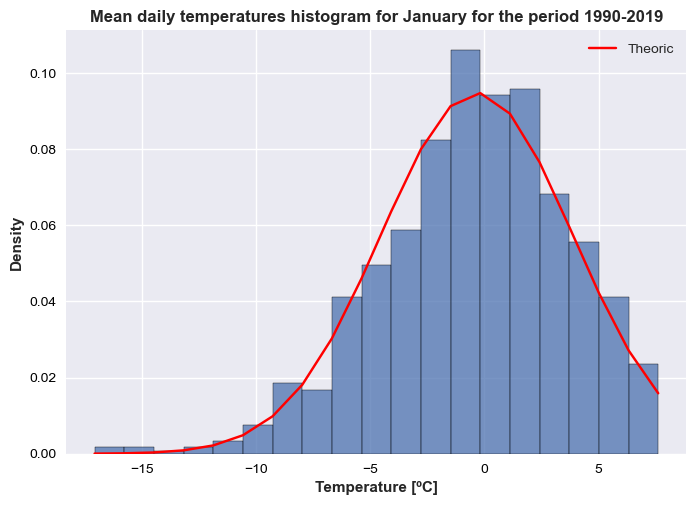

Percentiles for the data are: q(5%)=-7.64 and q(95%)= 6.23
Percentiles for the theoric distribution are: q(5%)=-7.26 and q(95%)= 6.59
Índice de Confianza del 95%
IC= [-0.34+-0.27] (ºC)
With scipy function:
(-0.6059780253902167, -0.06438966876720931)


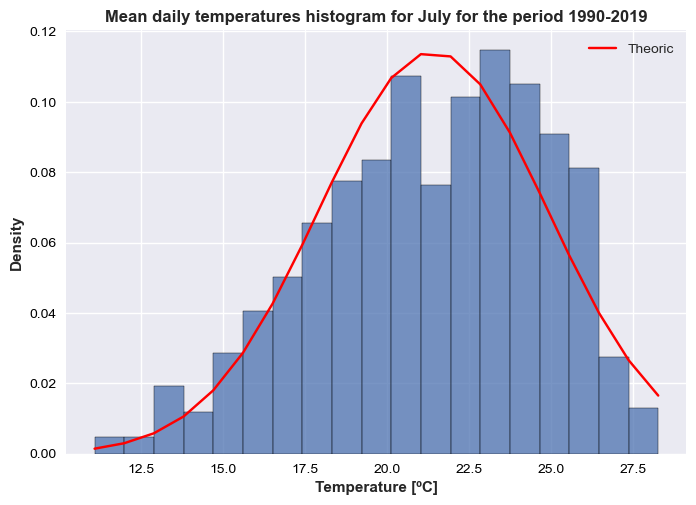

Percentiles for the data are: q(5%)=15.27 and q(95%)= 26.33
Percentiles for the theoric distribution are: q(5%)=15.66 and q(95%)= 27.15
Índice de Confianza del 95%
IC= [21.41+-0.22] (ºC)
With scipy function:
(21.181912648267012, 21.63150261655994)


In [53]:
# Llamamos a la función para representar el histograma y calcular los valores que piden para cada mes
histogram_plotter_with_normal_estimation(media_diaria_enero,'temp','Temperature [ºC]','Mean daily temperatures histogram for January for the period 1990-2019')
histogram_plotter_with_normal_estimation(media_diaria_julio,'temp','Temperature [ºC]','Mean daily temperatures histogram for July for the period 1990-2019')

#### 1.3.3 Cambio climático. Contraste de hipótesis

Calcula la media de la temperatura en enero y julio para el periodo 1973- 1989. Calcula la desviación típica de la temperatura en enero y julio para el periodo 1973-1989 y el periodo 1990-2019. Haz los contrastes de hipótesis pertinentes para decir si ha cambiado significativamente la temperatura en Barcelona en ambos periodos.


In [54]:
def ContrasteHipotesis(x1,x2,alpha):
    ''' Esta función calcula el contraste de hipótesis para la hipótesis nula de que las medias de dos series de datos de 
    poblaciones diferentes son iguales con un nivel de significancia alpha, y el contraste de hipótesis para la hipótesis 
    nula de que la razón de las varianzas de dos series temporales de poblaciones diferntes son iguales con un nivel de significancia alpha '''
    
    # Número de datos de cada serie
    n1=x1.size
    n2=x2.size

    #-------------------------------------------------------
    # Para el caso del contraste de hipótesis de las medias
    #-------------------------------------------------------
    # Calculo el estadístico
    z=np.abs(np.mean(x1)-np.mean(x2))/(np.sqrt((np.var(x1)/n1**2)+(np.var(x2)/n2**2)))

    # Calculo valor con el que voy a comparar la muestra, sigue una distribución normal, usamos norm.ppf. Hay que tener
    # en cuenta que z_alpha_2 es el valor que deja a su derecha un área de alpha_1, pero la función del paquete scipy
    # stats.norm.ppf() devuelve el valor que deja por DEBAJO, por lo que se tiene que introducir 1-alpha_2
    z_alpha_2 = stats.norm.ppf(1-alpha/2,loc=0,scale=1)

    # Comprobamos si se cumplen las premisas
    if z<=z_alpha_2:
        # En este caso se acepta la hipótesis
        print('Se acepta la hipótesis de que las medias son iguales con un nivel de significancia ', alpha)
    else:
        # En este caso no se acepta la hipótesis
        print('Se rechaza la hipótesis de que las medias son iguales con un nivel de significancia ', alpha)

    #-------------------------------------------------------
    # Para el caso del contraste de hipóteis de las varianzas
    #-------------------------------------------------------
    # Cálculo del estadístico
    f = np.var(x1)/np.var(x2)

    # Se define el intervalo de significancia para comparar con el estadístico
    interv_sig=stats.f.interval(alpha,n1,n2,loc=0,scale=1)

    #Comprobamos si se cumplen las premisas
    if f<interv_sig[0] and f>interv_sig[1]:
        # En este caso se acepta la hipótesis
        print(f'Se ha aceptado la hipotesis de que las varianzas son iguales con un nivel de significancia ', alpha)
    else:
        # En este caso no se acepta la hipótesis
        print(f'Se ha aceptado la hipotesis de que las varianzas son iguales con un nivel de significancia ', alpha)


Para hacer el contraste de hipótesis y decir si ha habido o no cambio climático, se compararán los datos del data set de la base de datos NCEP/NCAR
con los datos observados en la estación de Barajas

In [55]:
# Vamos a hacer los cálculos para el contraste de hipótesis

# Establecemos el nivel de significancia alpha en un 5%
alfa = 0.05

# Y llamamos a la función que hace el contraste de hipótesis
a = StadisticalTestats(x=media_diaria_enero['temp'], y=enero_last, alpha  = alfa)
b = StadisticalTestats(x=media_diaria_julio['temp'], y=julio_last, alpha = alfa)

# En los primeros dos espacios hay que meter o numpy.array o pd.Series
print('Enero')
# Test con la clase definida por nagore
a.mean_test()
a.f_test_manual()
print(' ')
# Test con la función definida
ContrasteHipotesis(media_diaria_enero['temp'], enero_last,alfa)

print(' ')
print(' ')
print(' ')

print('Julio')
# Test con la clase 
b.mean_test()
b.f_test_manual()
print(' ')
# Test con la función definida 
ContrasteHipotesis(media_diaria_julio['temp'], julio_last,alfa)

Enero
Se ha rechazado la hipotesis de que las medias son iguales con una confianza de 0.05.
Se ha aceptado la hipotesis de que las varianzas son iguales con una confianza de 0.05.
 
Se rechaza la hipótesis de que las medias son iguales con un nivel de significancia  0.05
Se ha aceptado la hipotesis de que las varianzas son iguales con un nivel de significancia  0.05
 
 
 
Julio
Se ha rechazado la hipotesis de que las medias son iguales con una confianza de 0.05.
Se ha aceptado la hipotesis de que las varianzas son iguales con una confianza de 0.05.
 
Se rechaza la hipótesis de que las medias son iguales con un nivel de significancia  0.05
Se ha aceptado la hipotesis de que las varianzas son iguales con un nivel de significancia  0.05


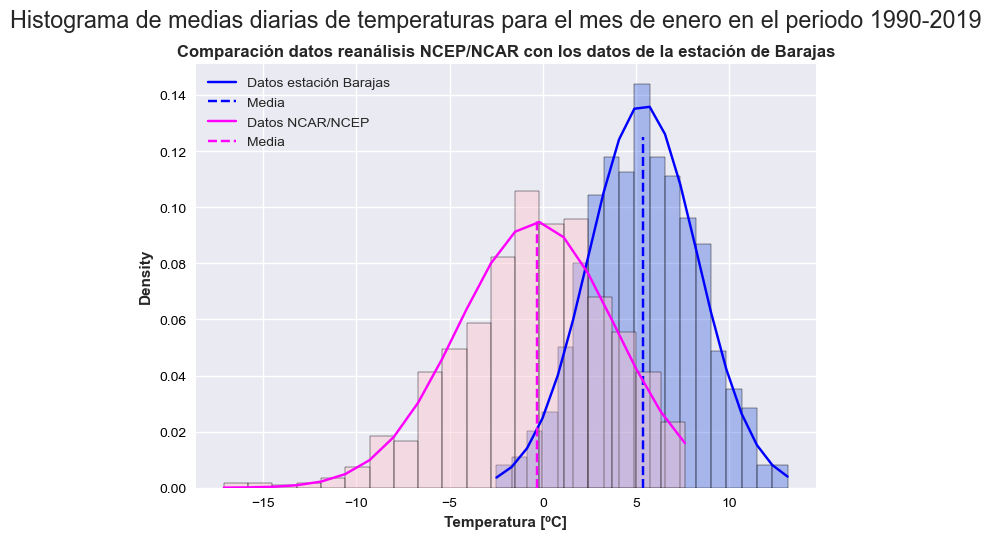

In [56]:
# Vamos a comparar con los datos de la estación del segundo periodo (enero_last)
mean= np.mean(enero_last)
std= np.std(enero_last)
n= np.shape(enero_last)[0]
bins= np.arange(np.min(enero_last),np.max(enero_last),step=(np.max(enero_last)-np.min(enero_last))/20)
fig,ax= plt.subplots()
sns.histplot(january_daily_mean_secondperiod, x='temp',bins=bins,stat='density',alpha=0.4,color='royalblue')
normal_distribution= stats.norm.pdf(bins,mean,std)
plt.plot(bins,normal_distribution,'blue',label='Datos estación Barajas')
alfa=0.05

x=np.zeros(10)
y=np.linspace(0,0.125,10)
plt.plot(x+mean,y,'--',color='blue',label='Media')

mean= np.mean(media_diaria_enero['temp'])
std= np.std(media_diaria_enero['temp'])
n= np.shape(media_diaria_enero['temp'])[0]
bins= np.arange(np.min(media_diaria_enero['temp']),np.max(media_diaria_enero['temp']),step=(np.max(media_diaria_enero['temp'])-np.min(media_diaria_enero['temp']))/20)
sns.histplot(media_diaria_enero, x='temp',bins=bins,stat='density',alpha=0.4,color='pink')
normal_distribution= stats.norm.pdf(bins,mean,std)
plt.plot(bins,normal_distribution,'magenta',label='Datos NCAR/NCEP')
y=np.linspace(0,0.095,10)
plt.plot(x+mean,y,'--',color='magenta',label='Media')

plt.legend(loc='best')
plt.xlabel('Temperatura [ºC]')
plt.title('Comparación datos reanálisis NCEP/NCAR con los datos de la estación de Barajas')
plt.suptitle('Histograma de medias diarias de temperaturas para el mes de enero en el periodo 1990-2019')
plt.show()

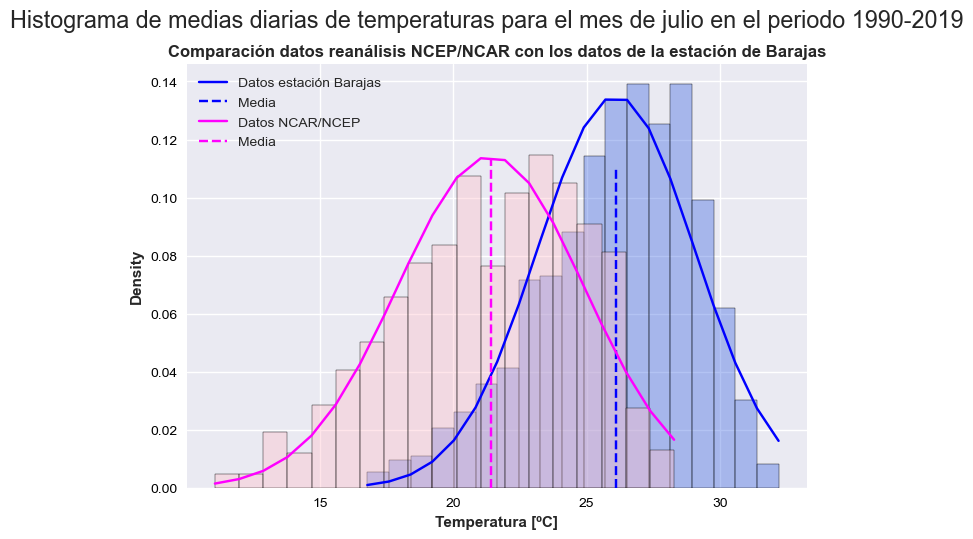

In [57]:
# Vamos a comparar con los datos de la estación del segundo periodo (julio_last)
mean= np.mean(julio_last)
std= np.std(julio_last)
n= np.shape(julio_last)[0]
bins= np.arange(np.min(julio_last),np.max(julio_last),step=(np.max(julio_last)-np.min(julio_last))/20)
fig,ax= plt.subplots()
sns.histplot(july_daily_mean_secondperiod, x='temp',bins=bins,stat='density',alpha=0.4,color='royalblue')
normal_distribution= stats.norm.pdf(bins,mean,std)
plt.plot(bins,normal_distribution,'blue',label='Datos estación Barajas')
alfa=0.05

x=np.zeros(10)
y=np.linspace(0,0.11,10)
plt.plot(x+mean,y,'--',color='blue',label='Media')

mean= np.mean(media_diaria_julio['temp'])
std= np.std(media_diaria_julio['temp'])
n= np.shape(media_diaria_julio['temp'])[0]
bins= np.arange(np.min(media_diaria_julio['temp']),np.max(media_diaria_julio['temp']),step=(np.max(media_diaria_julio['temp'])-np.min(media_diaria_julio['temp']))/20)
sns.histplot(media_diaria_julio, x='temp',bins=bins,stat='density',alpha=0.4,color='pink')
normal_distribution= stats.norm.pdf(bins,mean,std)
plt.plot(bins,normal_distribution,'magenta',label='Datos NCAR/NCEP')
y=np.linspace(0,0.113,10)
plt.plot(x+mean,y,'--',color='magenta',label='Media')

plt.legend(loc='best')
plt.xlabel('Temperatura [ºC]')
plt.title('Comparación datos reanálisis NCEP/NCAR con los datos de la estación de Barajas')
plt.suptitle('Histograma de medias diarias de temperaturas para el mes de julio en el periodo 1990-2019')
plt.show()

## Apartado 2

In [58]:
# Voy a leer los datos usando xarray
file = './data/HadISST1_sst_1870-2019.nc' 

ds=xr.open_dataset(file)

# Calculate the mean and std
ds_mean = ds.groupby('time.season').mean()
ds_std =  ds.groupby('time.season').std()

### 2.1 Caracterización de la climatología invierno / verano

Lee la base de datos (un solo fichero: HadISST1_sst_18702019.nc) y calcula los promedios
estacionales en cada punto de malla para cada año del invierno (diciembre, enero y febrero) y del
verano (junio, julio y agosto), separadamente.
Representa la media de todos los años y la desviación típica en mapas 2D. Comenta los resultados.

Text(0.5, 1.02, 'Seasonal Surface Air Temperature')

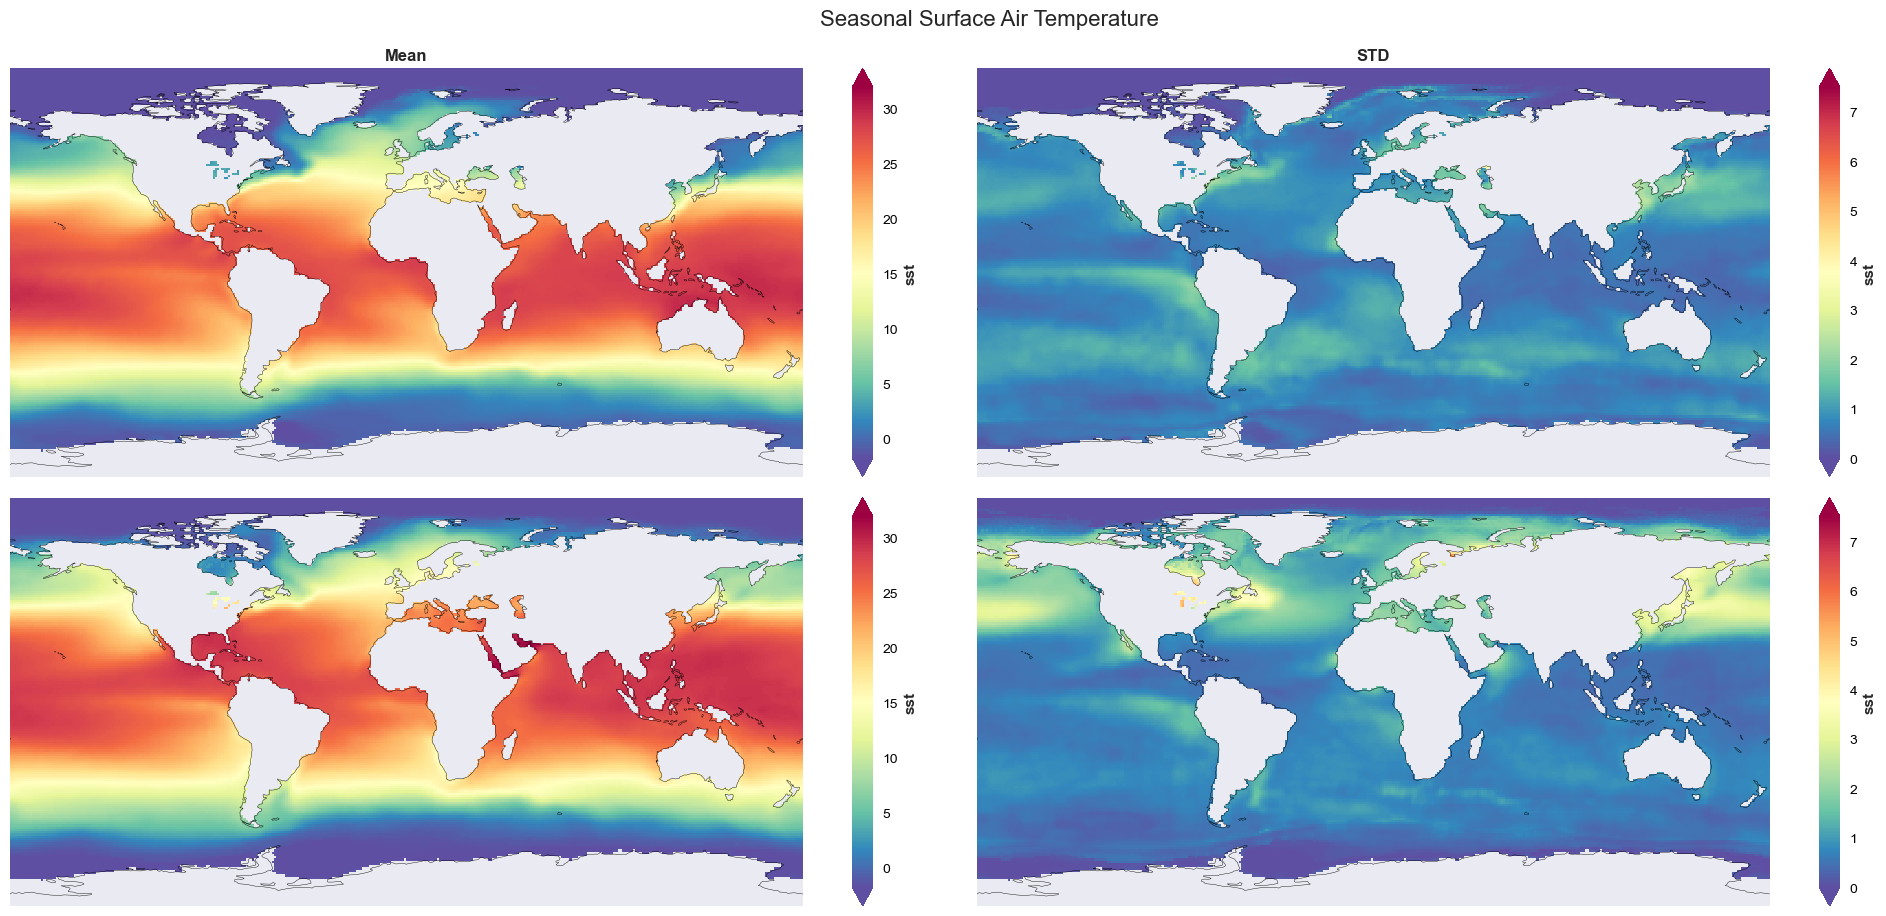

In [59]:
# Quick plot to show the results
fig, axes = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20, 9))
                        
for i, season in enumerate(("DJF","JJA")):
    ds_mean["sst"].sel(season=season).plot.pcolormesh(
        ax=axes[i, 0],
        vmin=ds_mean["sst"].min(),
        vmax=ds_mean["sst"].max(),
        cmap="Spectral_r",
        add_colorbar=True,
        extend="both",
    )

    ds_std["sst"].sel(season=season).plot.pcolormesh(
        ax=axes[i, 1],
        vmin=ds_std["sst"].min(),
        vmax=ds_std["sst"].max(),
        cmap="Spectral_r",
        add_colorbar=True,
        extend="both",
    )

    axes[i, 0].set_ylabel(season)
    axes[i, 1].set_ylabel("")

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis("tight")
    ax.set_xlabel("")

axes[0, 0].set_title("Mean")
axes[0, 1].set_title("STD")
axes[1, 0].set_title('')
axes[1, 1].set_title('')

# Set coastlines
axes[0, 0].coastlines()
axes[0, 1].coastlines()
axes[1, 0].coastlines()
axes[1, 1].coastlines()

plt.tight_layout()

fig.suptitle('Seasonal Surface Air Temperature', fontsize=16, y=1.02)

### 2.2 Calcula la media y la desviación típica en el periodo 1870-1930, 1931-1975 y 1975-2019 y representa.

- Mapas de diferencia de medias '1976-2019 menos 1870-1930' y '1931-1975 menos 1870-
1930'. Indica con puntos las regiones donde ha habido un cambio significativo en la media a
un nivel de confianza del 95%
- Mapas de razón de varianzas '1976-2019 / 1870-1930' y '1931-1975 / 1870-1930'. Indica
con puntos las regiones donde ha habido un cambio significativo en la variabilidad a un
nivel de confianza del 95%

In [60]:
# Primer periodo
sample_1 = ds['sst'].sel(time=slice('1870', '1930'))

# Secondo periodo
sample_2 = ds['sst'].sel(time=slice('1931', '1975'))

# Tercer periodo
sample_3 = ds['sst'].sel(time=slice('1976', '2019'))

In [61]:
# Calculo de la diferencia de los periodos: tercero - primero
dif_1 = sample_3.mean(dim='time') - sample_1.mean(dim='time') 

# Calculo de la diferencia de los periodos: tercero - segundo
dif_2 = sample_3.mean(dim='time')  - sample_2.mean(dim='time')  

In [62]:
# Razón de varianzas
var_1 = sample_3.var(dim='time')/sample_1.var(dim='time')
var_2 = sample_3.var(dim='time')/sample_2.var(dim='time') 

In [63]:
# Funciones de Belén

# Para las medias
def testt(sample1, sample2, alfa):
    z_alpha_2 = stats.norm.ppf(1-alfa/2)
    
    [nt1,nf,nc]=np.shape(sample1)
    [nt2,nf,nc]=np.shape(sample2)
    
    z = abs(sample1.mean(dim='time') - sample2.mean(dim='time'))/np.sqrt(sample1.var(dim='time', ddof=1)/nt1 + sample2.var(dim='time', ddof=1)/nt2)
    
    A = z<z_alpha_2
   
    mx = ma.masked_array(sample1.mean(dim='time') - sample2.mean(dim='time'), A)
    return A, mx

# Para las varianzas
def testt_f (sample1,sample2, alfa):
    
    nt1 = np.shape(sample1)[0]
    nt2 = np.shape(sample2)[0]
    
    f1 = stats.f.ppf(alfa/2,  dfn = nt1-1, dfd = nt2-1)
    f2 = stats.f.ppf(1-alfa/2, dfn = nt1-1, dfd = nt2-1)
    
    F = (sample1.var(dim='time', ddof=1) / sample2.var(dim='time', ddof=1))
    A = (f1<=F) & (F<=f2)
    
    mx = ma.masked_array(sample1.var(axis=0,ddof=1)/sample2.var(axis=0,ddof=1), A)
    return A, mx

In [64]:
# Cálculo de las medias
A, mx   = testt(sample_3, sample_1, 0.05)
A2, mx2 = testt(sample_2, sample_1, 0.05)

Text(0.5, 1.02, 'Mapas de diferencia de medias')

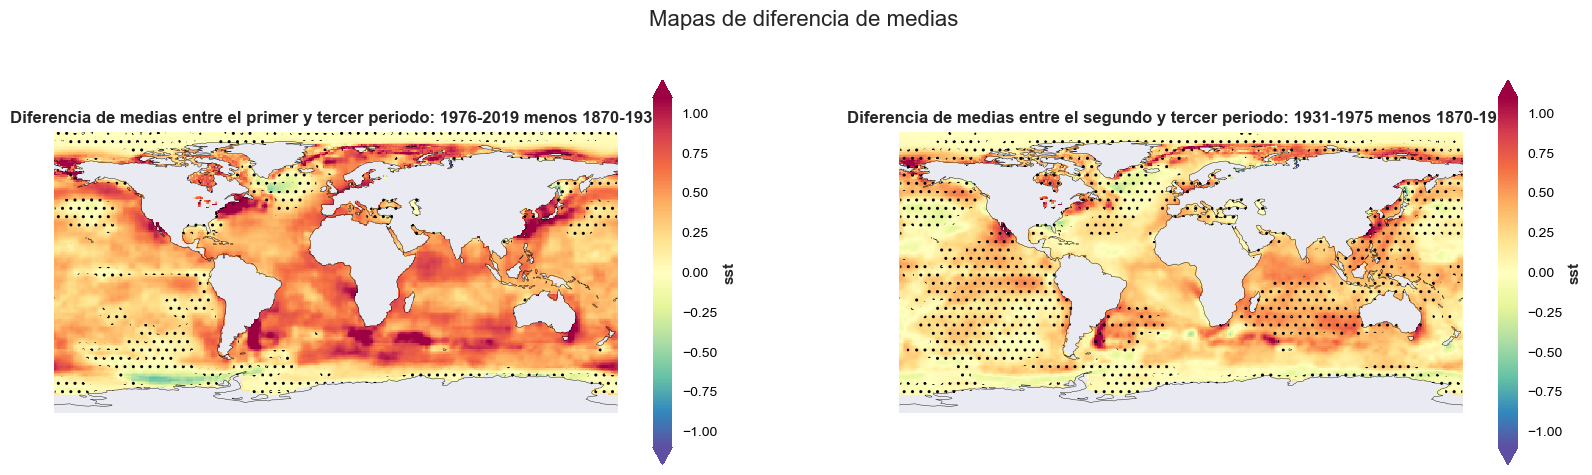

In [65]:
# Gráfica de las diferencias
fig, axes = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20, 5))
dif_1.plot.pcolormesh(
        ax=axes[0],
        vmin=-1.1,
        vmax=1.1,
        cmap="Spectral_r",
        add_colorbar=True
    )
A.plot.contourf(ax = axes[0],  levels = [True, False], 
                      hatches=[None, '..'],
                      extend ='both',colors='none',
                      add_colorbar=False)

dif_2.plot.pcolormesh(
        ax=axes[1],
        vmin=-1.1,
        vmax=1.1,
        cmap="Spectral_r",
        add_colorbar=True
        
    )

A2.plot.contourf(ax = axes[1],  levels = [True, False], 
                      hatches=[None, '..'],
                      extend ='both',colors='none',
                  add_colorbar=False)

# Add coastlines
axes[0].coastlines()
axes[1].coastlines()

# Poner nombres a los ejes
axes[0].set_ylabel('Latitude')
axes[1].set_ylabel('Latitude')

axes[0].set_xlabel('Longitude')
axes[1].set_xlabel('Longitude')

# Poner titulos a las gráficas
axes[0].set_title("Diferencia de medias entre el primer y tercer periodo: 1976-2019 menos 1870-1930")
axes[1].set_title("Diferencia de medias entre el segundo y tercer periodo: 1931-1975 menos 1870-1930")

fig.suptitle('Mapas de diferencia de medias', fontsize=16, y=1.02)

In [66]:
# Calculo del test de varianzas
A, mx   = testt_f(sample_3, sample_1, 0.05)
A2, mx2 = testt_f(sample_2, sample_1, 0.05)

Text(0.5, 1.02, 'Mapas de razon de varianzas')

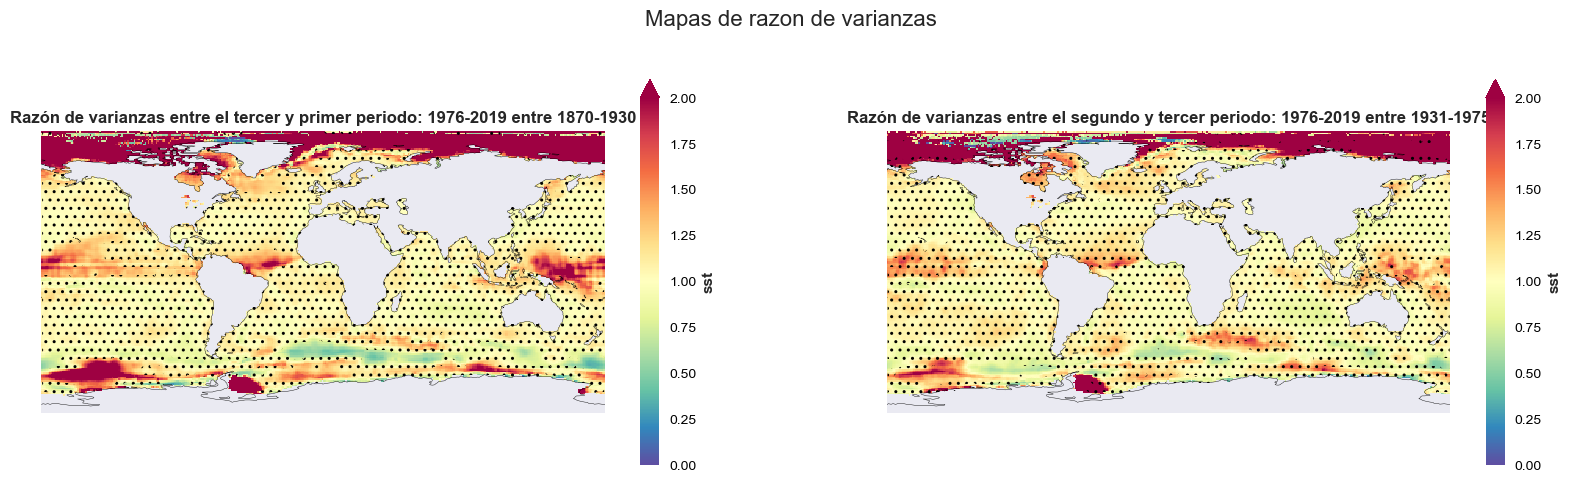

In [67]:
fig, axes = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20, 5))
var_1.plot.pcolormesh(
        ax=axes[0],
        vmin=0,
        vmax=2,
        cmap="Spectral_r",
        add_colorbar=True
    )
A.plot.contourf(ax = axes[0], levels = [False, True], 
                      hatches=[None, '..'],  
                      extend ='both',colors='none',
                      add_colorbar=False)

var_2.plot.pcolormesh(
        ax=axes[1],
        vmin=0,
        vmax=2,
        cmap="Spectral_r",
        add_colorbar=True
        
    )
A2.plot.contourf(ax = axes[1], levels = [True, False], 
                      hatches=[None, '..'], 
                      extend ='both', colors='none',
                      add_colorbar=False)
# Add coastlines
axes[0].coastlines()
axes[1].coastlines()

# Poner nombres a los ejes
axes[0].set_ylabel('Latitude')
axes[1].set_ylabel('Latitude')

axes[0].set_xlabel('Longitude')
axes[1].set_xlabel('Longitude')

# Poner titulos a las gráficas
axes[0].set_title("Razón de varianzas entre el tercer y primer periodo: 1976-2019 entre 1870-1930")
axes[1].set_title("Razón de varianzas entre el segundo y tercer periodo: 1976-2019 entre 1931-1975")

fig.suptitle('Mapas de razon de varianzas', fontsize=16, y=1.02)

### 2.3 Evaluación de las series temporales de anomalías en distintas regiones para el periodo completo.
Calcula la anomalía mensual (a cada mes de cada año hay que restarle la media de ese mes para
todos los años) en 3 regiones diferentes:
- Pacífico (17090ºW, 5ºS5ºN)
- Atlántico (70ºW0, 0ºN60ºN)
- Índico (40110ºE, 30ºS25ºN)
Representa las series temporales promediando los datos regionales en cada región. Comenta los
resultados.

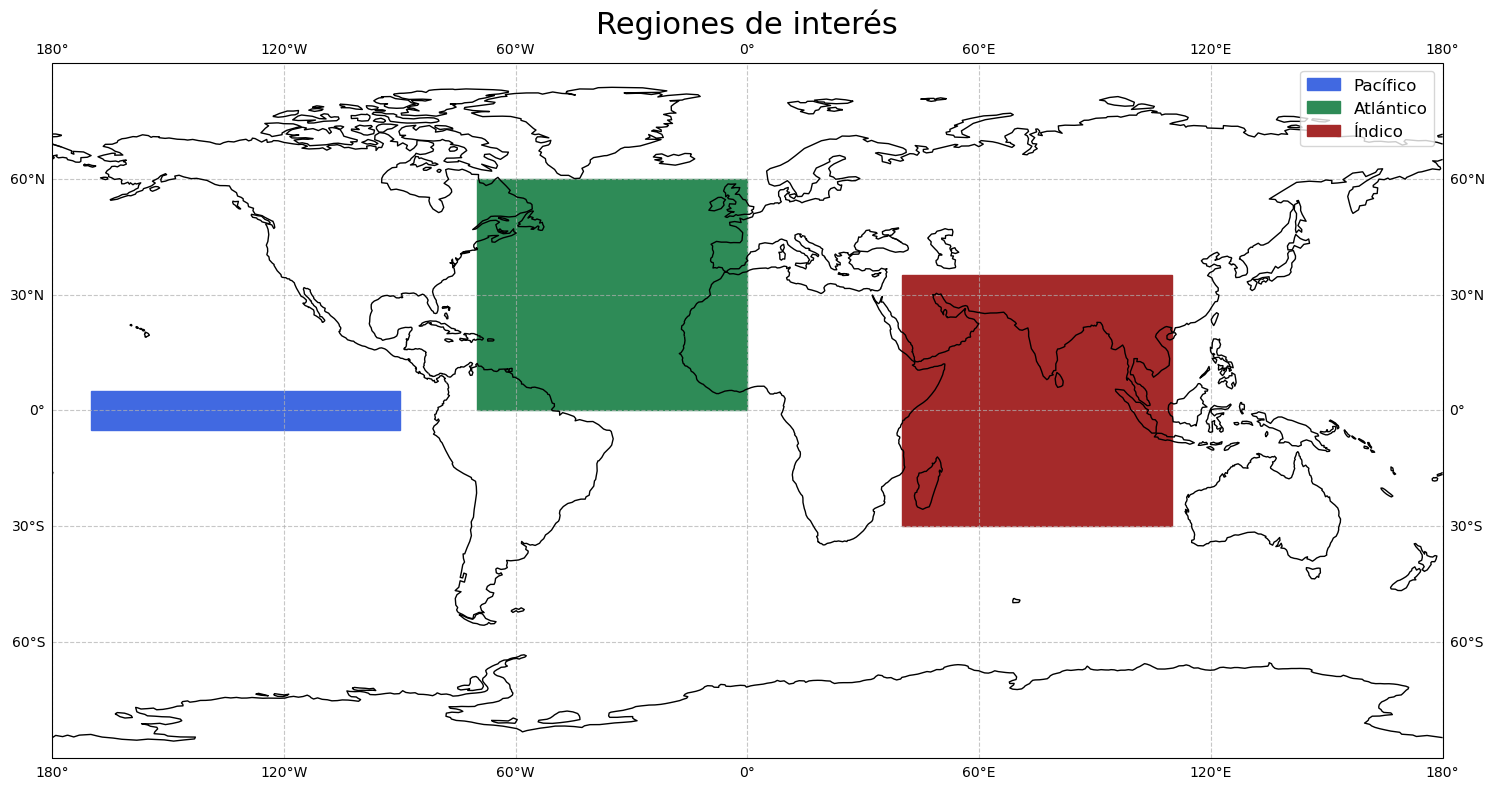

In [68]:
# Vamos a pintar las regiones en un mapa para verlas mejor
plt.style.use('default') # Estilo general
fig, ax = plt.subplots(figsize=(16, 8), ncols=1)
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax.coastlines(resolution='110m')

ax.set_global() # added following an answer to my question

ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)
def pinta_region(lats,lons,color,ax=ax,label=None):
    lat_corners = np.array([lats[0], lats[0],lats[1], lats[1]])
    lon_corners = np.array([ lons[0], lons[1], lons[1], lons[0]])
    poly_corners = np.zeros((len(lat_corners), 2), np.float64)
    poly_corners[:,0] = lon_corners
    poly_corners[:,1] = lat_corners
    poly = mpatches.Polygon(poly_corners, closed=True, ec=color, fill=True, lw=1, fc=color,label=label)#, transform=ccrs.Geodetic())
    ax.add_patch(poly)

ax.set_title('Regiones de interés',size=22)
pinta_region([-5,5],[-170,-90],'royalblue',ax,label='Pacífico')
pinta_region([0,60],[-70,0],'seagreen',ax,label='Atlántico')
pinta_region([-30,35],[40,110],'brown',ax,label='Índico')
ax.legend(prop={'size':12})
plt.tight_layout()
fig.savefig('Regiones.png',dpi=500,facecolor='w')

In [69]:
# Lectura del fichero con netCDF4 (datos mensuales de 1870 a 2019)
file=u'./data/HadISST1_sst_1870-2019.nc' 
fil = nc.Dataset(file,'r') # Leemos con netCDF4
fil.variables.keys()

dict_keys(['longitude', 'latitude', 'time', 'sst'])

In [70]:
# Recogemos cada variable y pasamos los tiempos a formato de fechas
lon = fil.variables['longitude'][:]
lat = fil.variables['latitude'][:]
tiempo = fil.variables['time'] # Sin los dos puntos para que sea variable ncdf, con ellos es un masked array
sst = fil.variables['sst'][:]

tiempodates = nc.num2date(tiempo[:],tiempo.units,only_use_cftime_datetimes=False,only_use_python_datetimes=True) # Cambiamos el tiempo a un array de fechas Dia-Mes-Año
# Los últimos 2 parámetros que le paso a la función son para que guarde las fechas en el formato datetime de python (que funciona con pyplot), en vez de en cftime


In [71]:
# Función de cálculo de las series de anomalías
def regional_monthly_anomalies(var:np.ndarray,lonmin:float,lonmax:float,latmin:float,latmax:float,standardized=False):
    '''Función para calcular las anomalias mesuales de una cierta variable en una cierta región geográfica, a partir de datos mensuales 
    a distintas longitud y latitud.

    Entradas:
    -> var: el array con los datos de la variable, en forma (tiempo,latitud,longitud)
    -> lonmin: longitud mínima de la región
    -> lonmax: longitud máxima de la región
    -> latmin: latitud mínima de la región
    -> latmax: latitud máxima de la región
    -> standardized: booleano, si se quieren considerar anomalias estandarizadas, fijar a True
    
    Salida: array de anomalías mensuales de la variable, en forma (año,mes)
    '''

    nt, nlat, nlon = sst.shape  # Cojo los números de cada coordenada de la forma del array var
    nm = 12                     # Número de meses
    ny = int(nt/nm)             # Número de años = tiempos/(12 meses)
    region_var = var[:,:,(lon>lonmin)&(lon<lonmax)][:,(lat>latmin)&(lat<latmax),:].mean(axis=(1,2)) # Selecionamos la región y promediamos
    region_var = np.reshape(region_var,[ny,nm]) # Damos forma al array 1d para que sea 2d con forma (años,meses)

    regional_month_anom = np.zeros_like(region_var) # Creamos un array de ceros como el del valor de la variable en la región
    if standardized == False:   # Si no se quiere que sea estandarizada
        for mes in range(12):   # Recorremos los meses
            regional_month_anom[:,mes] = region_var[:,mes]-region_var[:,mes].mean() # Anomalía= Valor mesual en un año - Media del mes
    if standardized == True:    # Si se quiere que sea estandarizada, dividimos por la desviación estandar
        for mes in range(12):
            regional_month_anom[:,mes] = (region_var[:,mes]-region_var[:,mes].mean())/region_var[:,mes].std()
    
    return regional_month_anom

In [72]:
# Cambio de los parámetros de la representación
plt.style.use('seaborn') # Estilo general

font = {'size'   : 14}
plt.rc('font', **font) # Tamaño generico de fuentes
parameters = {'xtick.labelsize':14,
              'ytick.labelsize':14,
              'axes.labelsize':14,
              'axes.labelweight':'bold',
              'axes.titleweight':'bold',
              'axes.titlesize':18,
              'legend.fontsize':15,
              'legend.frameon':True,
              'legend.facecolor':'w',
              'legend.title_fontsize':16,
              'ytick.major.size': 3.5,
              'ytick.major.width': 0.8,
              'xtick.major.size': 3.5,
              'xtick.major.width': 0.8,  
              'axes.linewidth':1,
              'axes.edgecolor':'grey',
              'xtick.color':'grey',
              'xtick.labelcolor':'k',
              'ytick.color':'grey',
              'ytick.labelcolor':'k'}
plt.rcParams.update(parameters)

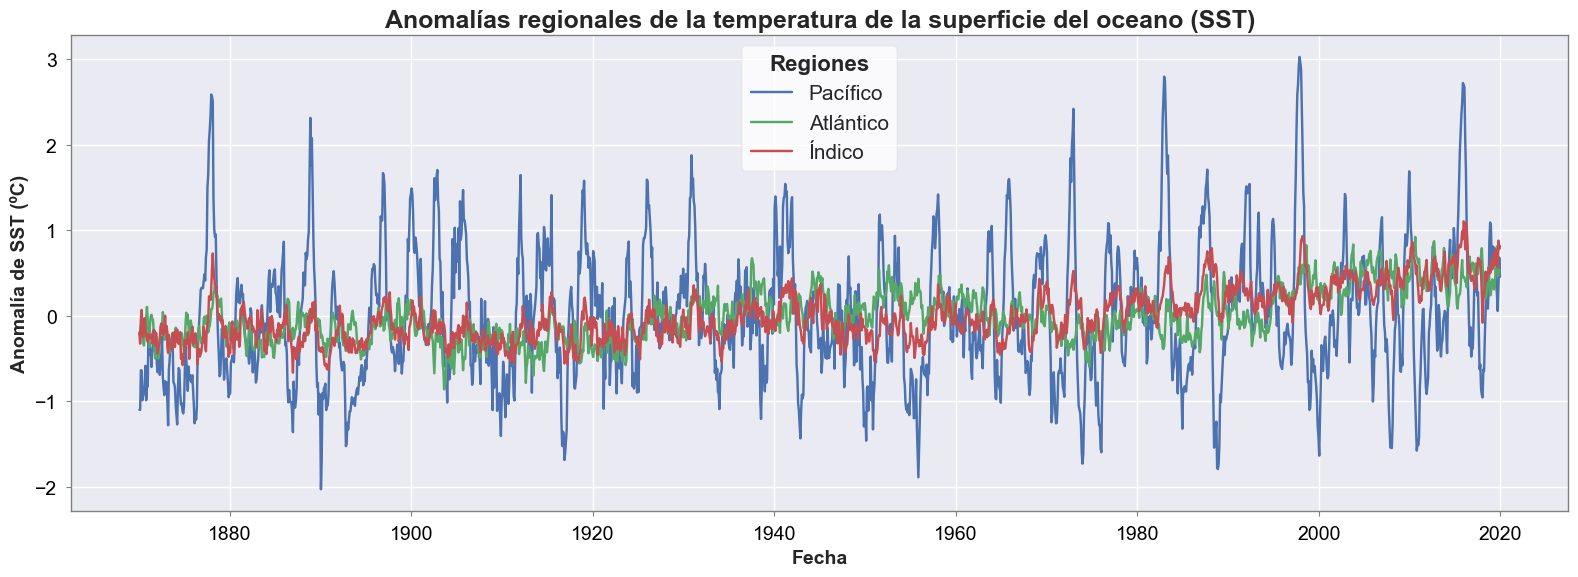

In [73]:
# Cálculo de las anomalías para cada una de las regiones
pacific_anom = regional_monthly_anomalies(sst,-170,-90,-5,5).ravel() # ravel() para que lo ponga como un array 1d
atlantic_anom = regional_monthly_anomalies(sst,-70,0,0,60).ravel()
indic_anom = regional_monthly_anomalies(sst,40,110,-30,25).ravel()


fig,ax = plt.subplots(figsize = (16,6))
ax.plot(tiempodates,pacific_anom,label='Pacífico')
ax.plot(tiempodates,atlantic_anom,label='Atlántico')
ax.plot(tiempodates,indic_anom,label='Índico')
ax.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax.set_xlabel('Fecha')
ax.set_ylabel('Anomalía de SST (ºC)')
ax.set_title('Anomalías regionales de la temperatura de la superficie del oceano (SST)')
plt.tight_layout()
fig.savefig('anom.png',dpi=600,facecolor='w')

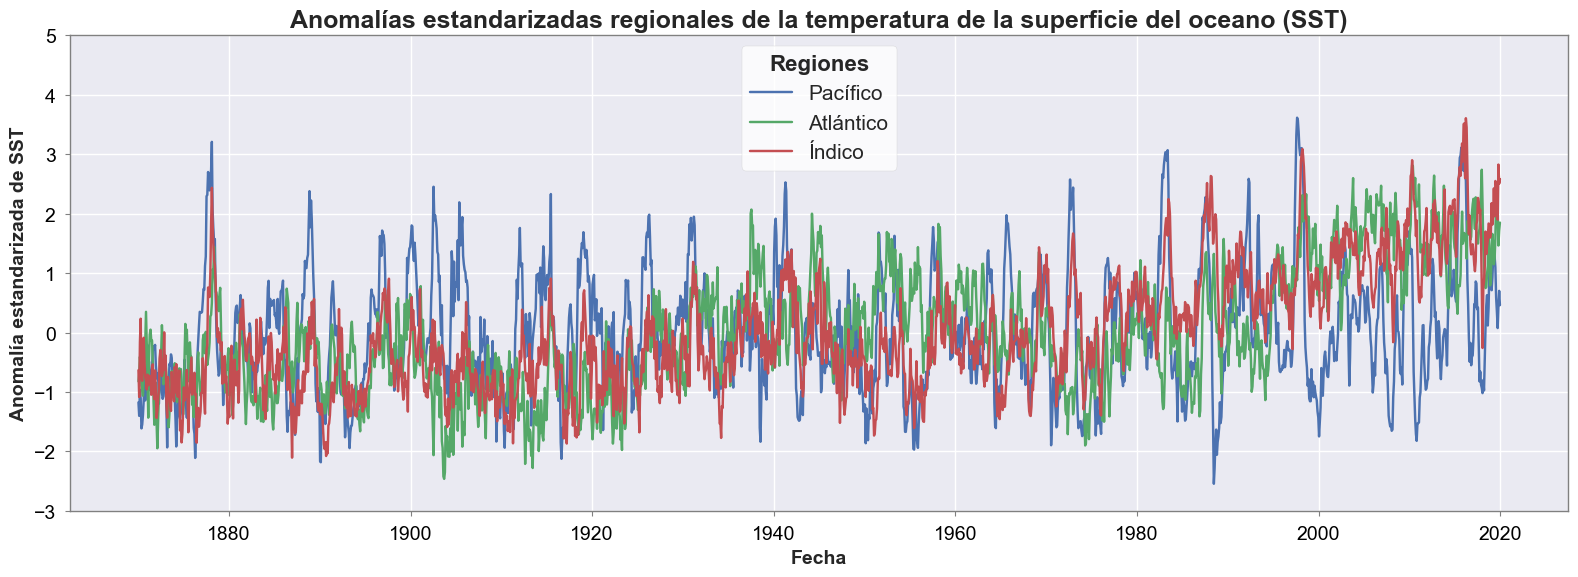

In [74]:
# Cálculo de las anomalías estandarizadas para cada una de las regiones
pacific_anom = regional_monthly_anomalies(sst,-170,-90,-5,5,standardized=True).ravel() # ravel() para que lo ponga como un array 1d
atlantic_anom = regional_monthly_anomalies(sst,-70,0,0,60,standardized=True).ravel()
indic_anom = regional_monthly_anomalies(sst,40,110,-30,25,standardized=True).ravel()

fig,ax = plt.subplots(figsize = (16,6))
ax.plot(tiempodates,pacific_anom,label='Pacífico')
ax.plot(tiempodates,atlantic_anom,label='Atlántico')
ax.plot(tiempodates,indic_anom,label='Índico')
ax.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax.set_xlabel('Fecha')
ax.set_ylabel('Anomalía estandarizada de SST')
ax.set_ylim(-3,5) # Para que quepa mejor la leyenda
ax.set_title('Anomalías estandarizadas regionales de la temperatura de la superficie del oceano (SST)')
plt.tight_layout()

fig.savefig('anom_std.png',dpi=600,facecolor='w')